# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


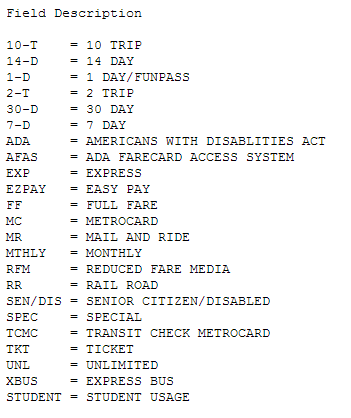

In [2]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

import datetime
# datetime.date(2014,2,19)-datetime.date(2010,5,19)

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [3]:
! wget -c "https://github.com/fedhere/PUI2018_fb55/blob/master/HW11_fb55/MTA_Fare.npy?raw=true" -O "MTA_Fare.npy"

--2018-12-03 02:23:04--  https://github.com/fedhere/PUI2018_fb55/blob/master/HW11_fb55/MTA_Fare.npy?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy [following]
--2018-12-03 02:23:04--  https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy [following]
--2018-12-03 02:23:04--  https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP r

In [5]:
!mv MTA_Fare.npy $PUIDATA

mv: cannot stat 'MTA_Fare.npy': No such file or directory


In [68]:
mta = np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy")

In [69]:
mta[0].shape
# 23 rows - >> 23 ridetypes
# 194 cols - >> 194 weeks 

(23, 194)

In [70]:
len(mta[0][1])

194

In [71]:
data = np.where(mta == -1, nan, mta)

In [7]:
print ("MTA array shape:", data.shape)
print ("MTA array shape summed over all ride types:", np.nansum(data,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [8]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

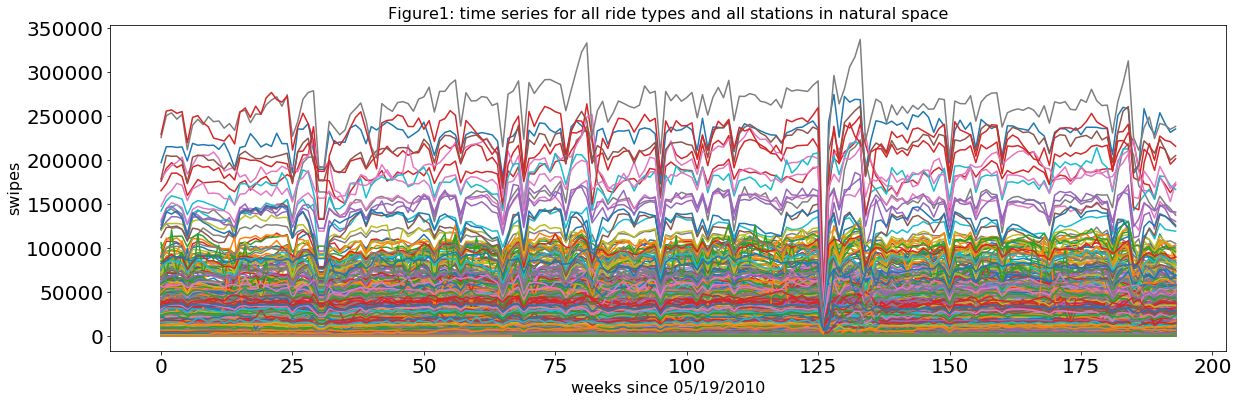

In [9]:
# plot the data in natural space
dataset = data
plt.figure(figsize=(20,6))
# all stations
# len(dataset) = 600 -> 600 stations 
# dataset[i][j] -> ith station jth ridetype 
for i in range(0, len(dataset)):
    for j in range(0, len(dataset[i])):
        mtaRidesPerWeek = pd.DataFrame(dataset[i][j]) # 1,194
        plt.plot(range(0, 194), mtaRidesPerWeek)
            
plt.title('Figure1: time series for all ride types and all stations in natural space', fontsize=16)
plt.xlabel('weeks since 05/19/2010', fontsize=16)
plt.ylabel('swipes', fontsize=16)

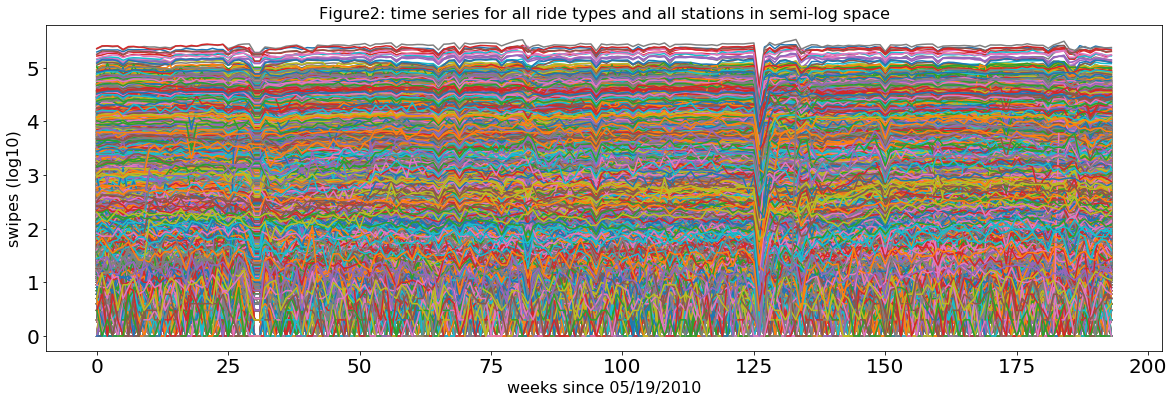

In [10]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
plt.figure(figsize=(20,6))
# all stations
# len(dataset) = 600 -> 600 stations 
# dataset[i][j] -> ith station jth ridetype 
for i in range(0, len(dataset)):
    for j in range(0, len(dataset[i])):
        mtaRidesPerWeek = pd.DataFrame(dataset[i][j]) # 1,194
        plt.plot(range(0, 194), np.log10(mtaRidesPerWeek))
            
plt.title('Figure2: time series for all ride types and all stations in semi-log space', fontsize=16)
plt.xlabel('weeks since 05/19/2010', fontsize=16)
plt.ylabel('swipes (log10)', fontsize=16)

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [12]:
mtaRidesPerWeek = np.nansum(np.nansum(data,axis=0),axis=0)
mtaRidesPerWeek.shape

(194,)

In [13]:
mean = mtaRidesPerWeek.mean()
std = mtaRidesPerWeek.std()
mean, std

(29781349.87113402, 2983960.421700886)

In [14]:
thresholds = [mean - 3 * std, mean + 3 * std]
thresholds

[20829468.606031362, 38733231.136236683]

In [15]:
week_outlier = np.where(mtaRidesPerWeek < thresholds[0])[0][0]
week_outlier

126

In [16]:
date_start = datetime.date(2010,5,19) + datetime.timedelta(days = (7 * int(week_outlier)))
date_end = datetime.date(2014,2,19) - datetime.timedelta(days = (7 * int(194 - week_outlier)))

print ("outlier start date :", date_start)
print ("outlier end date :", date_end)

outlier start date : 2012-10-17
outlier end date : 2012-10-31


### Cause of Dropdown Rideship:
I google "MTA subway 2012 Oct" and found some news about the Superstorm Sandy flooding.
https://www.apnews.com/0caa1f0bea4d41edae46849ad38d19d8

So the significant dropdown of subway ridership is due to the NYC MTA subway shutdown because of Hurricane Sandy.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [17]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [18]:
card_type = np.nansum(data,axis=0)
card_type.shape

(23, 194)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


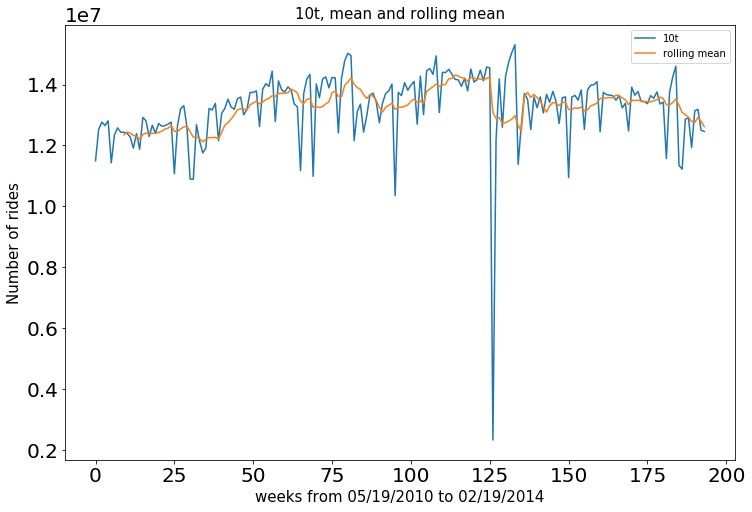

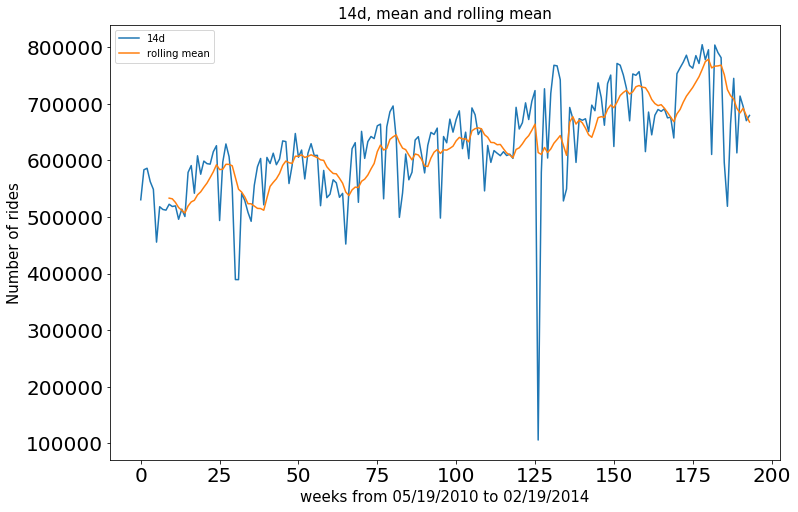

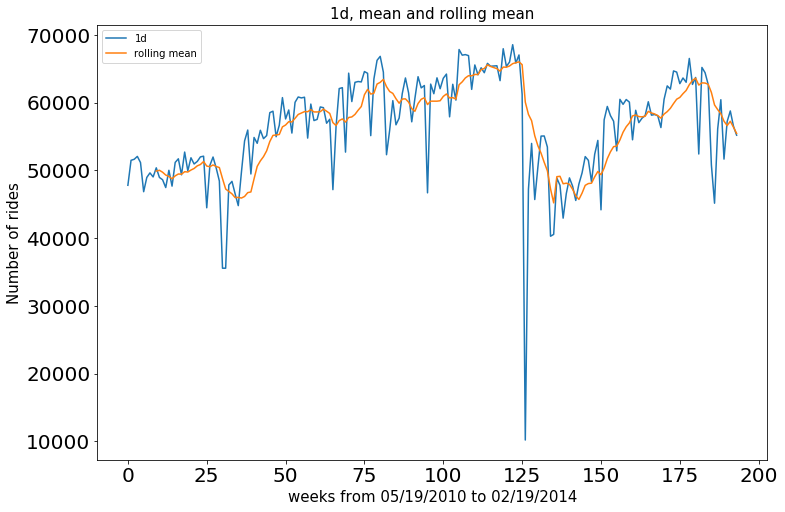

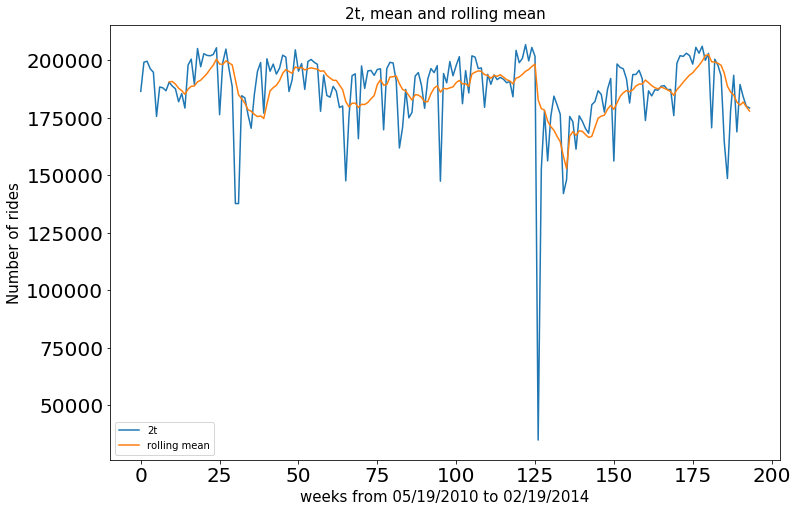

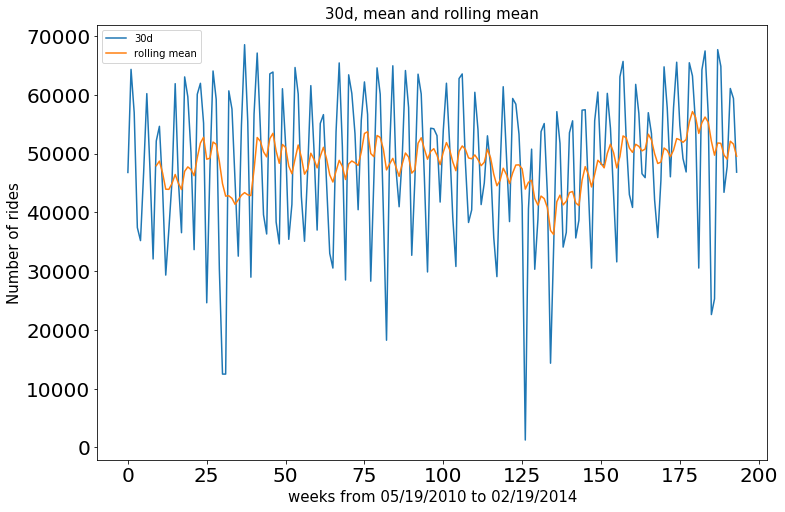

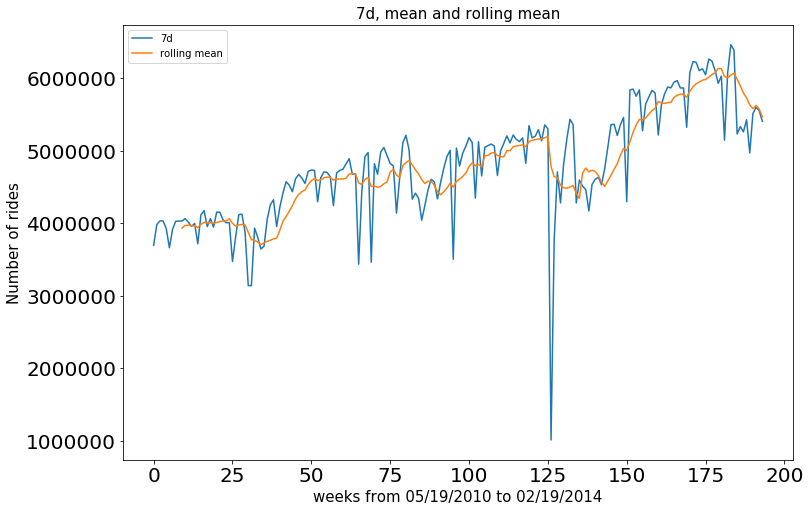

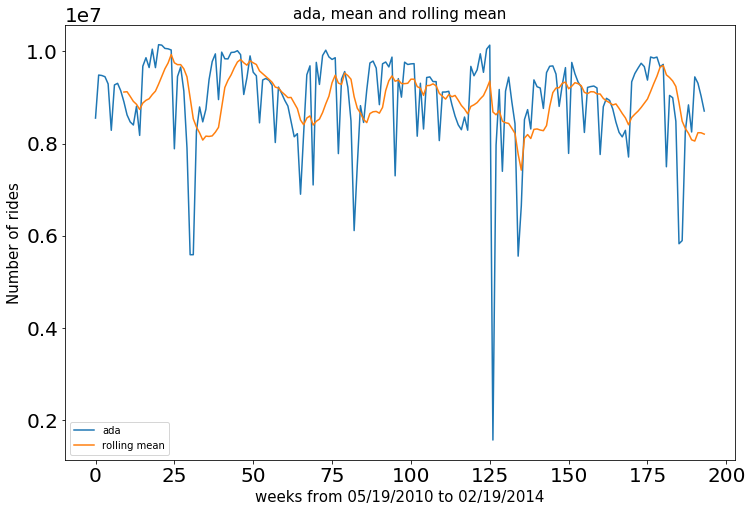

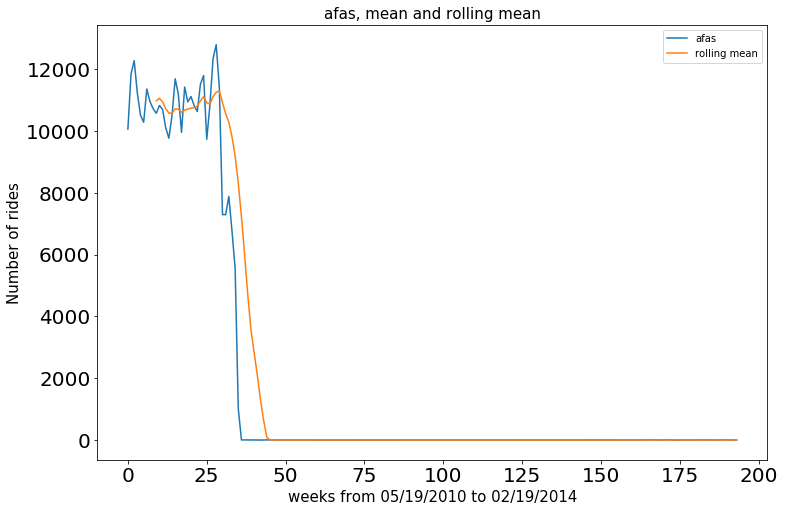

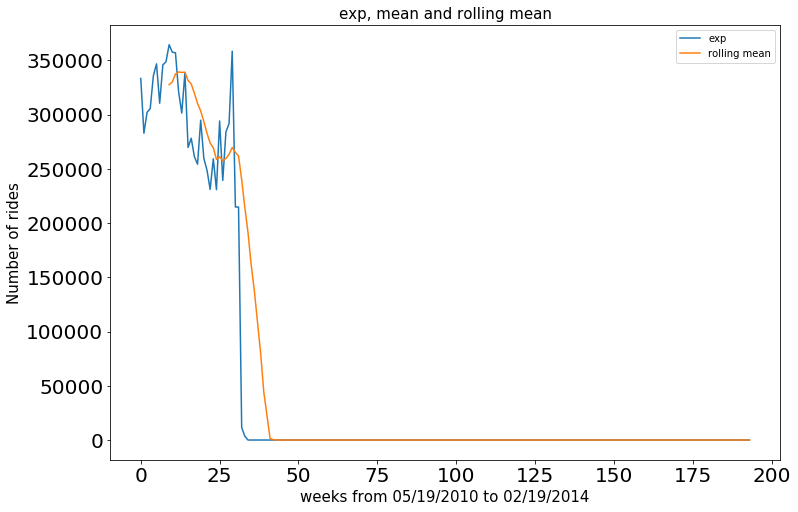

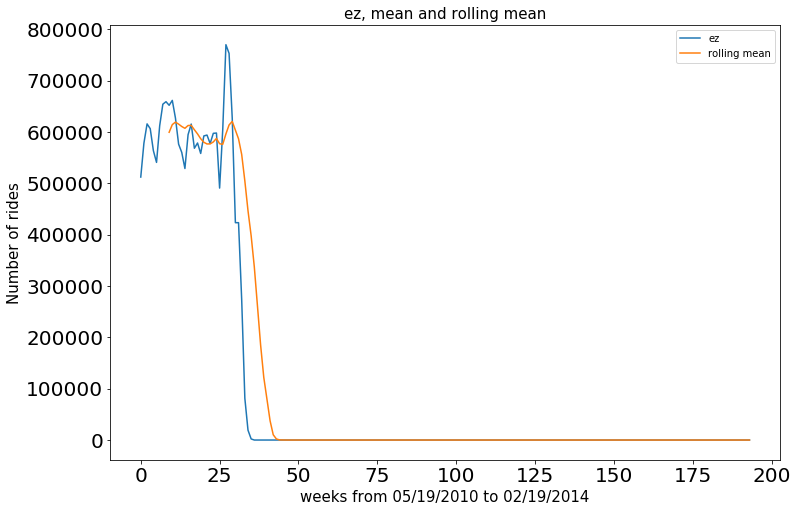

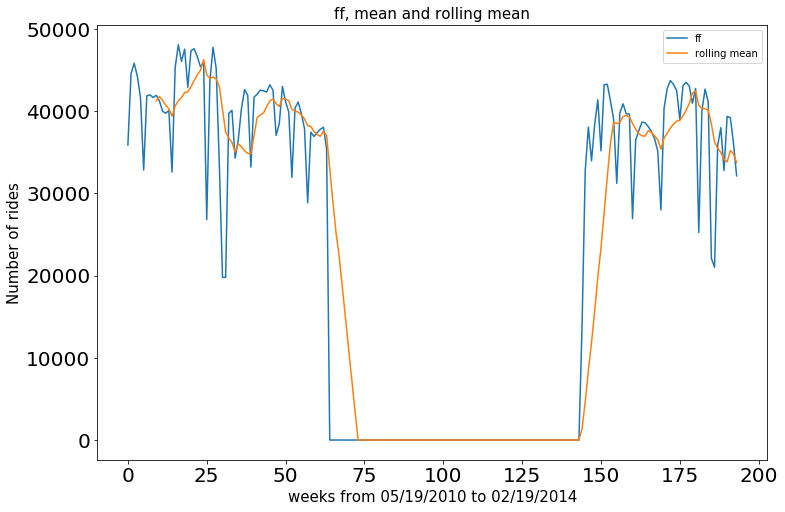

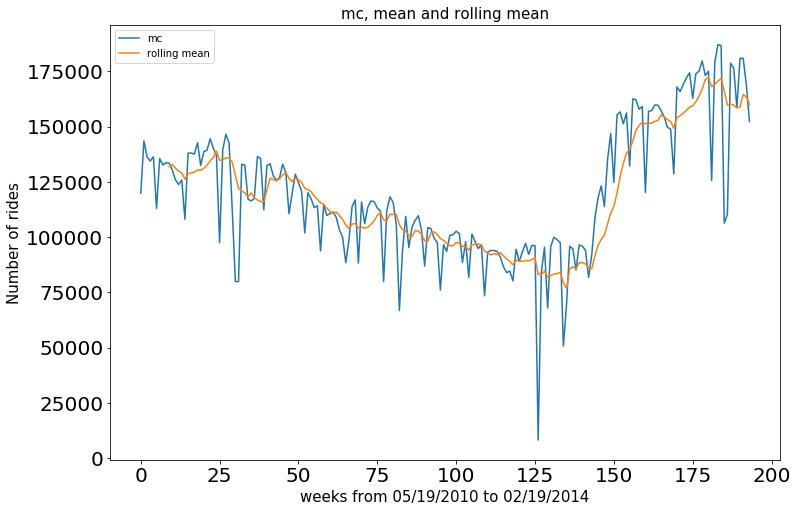

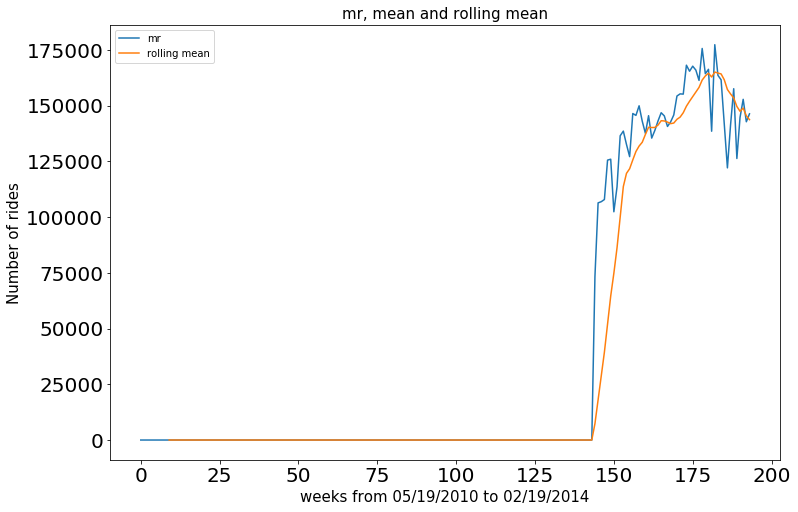

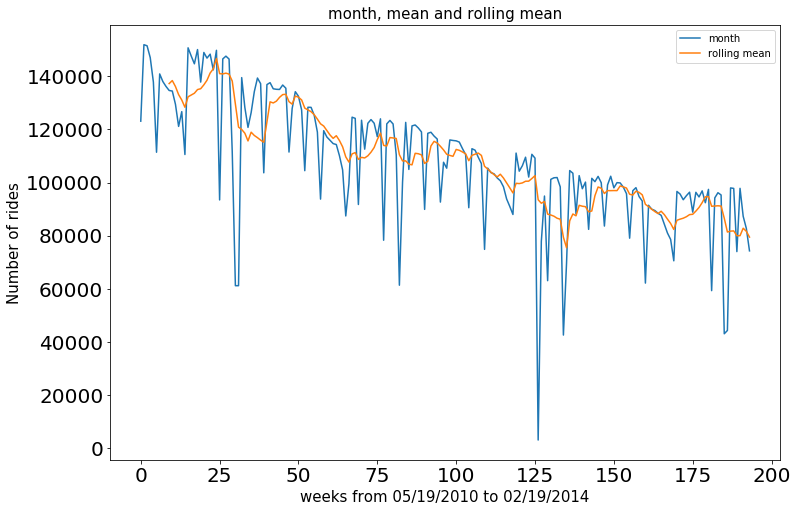

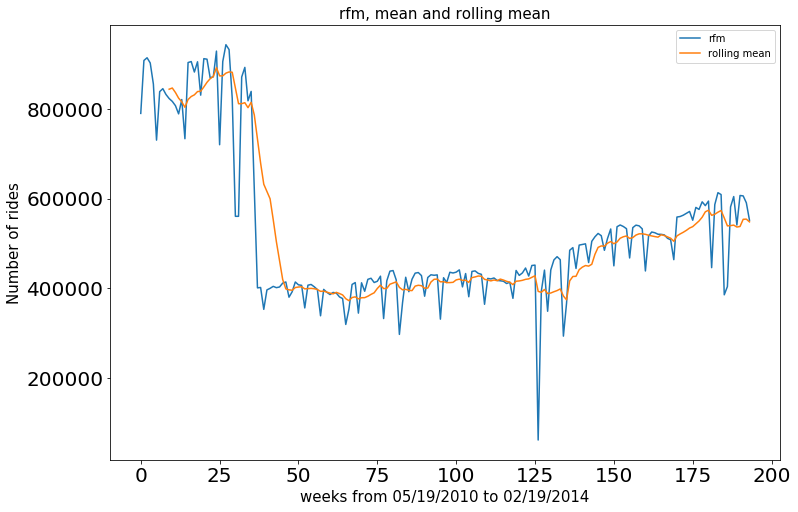

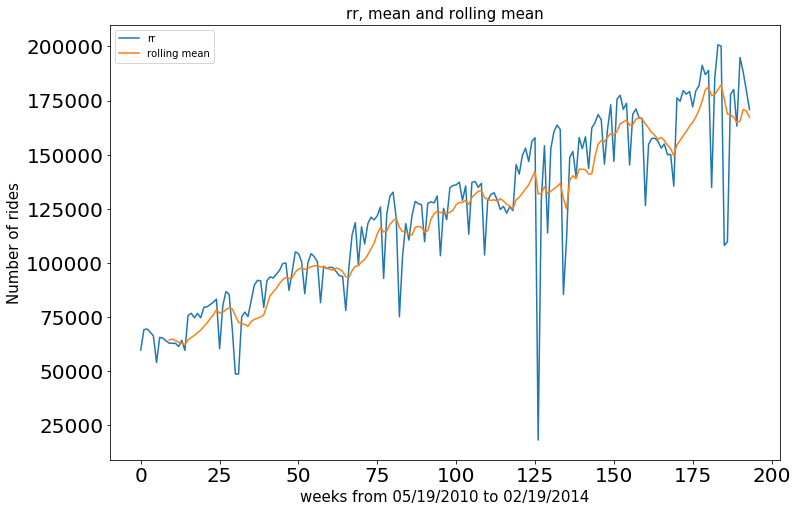

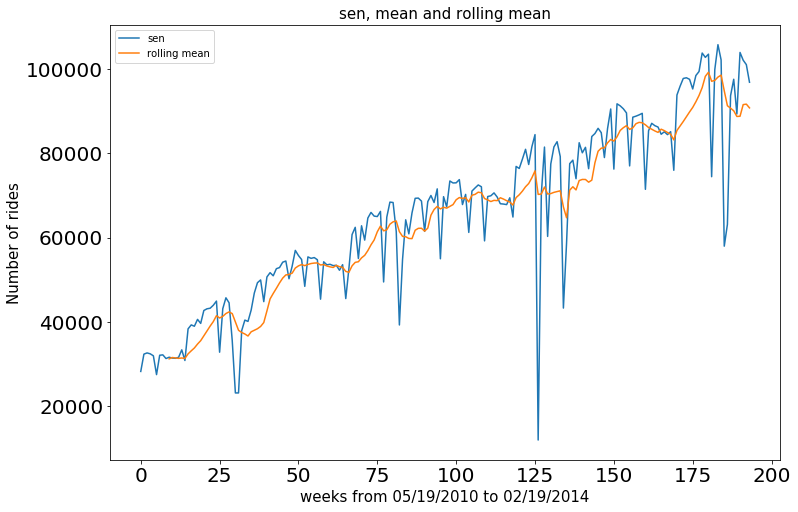

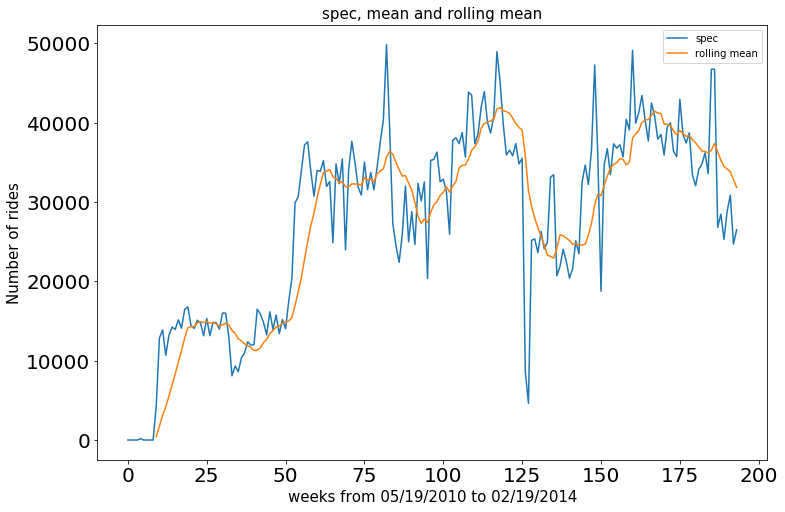

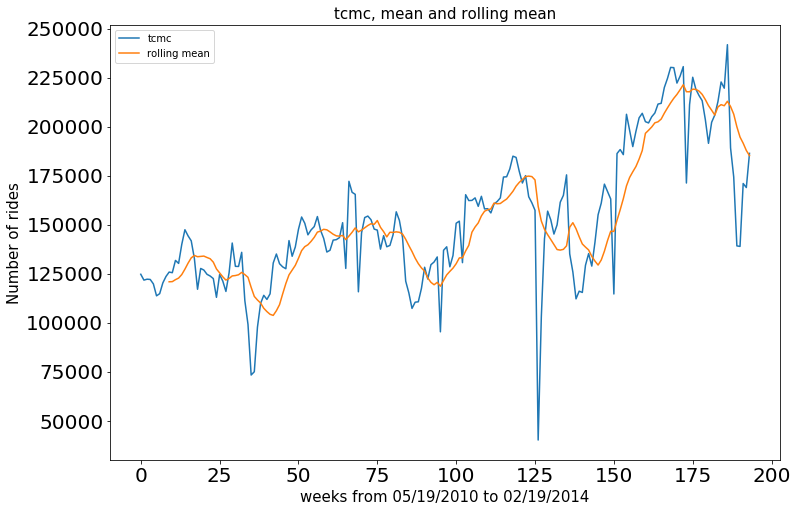

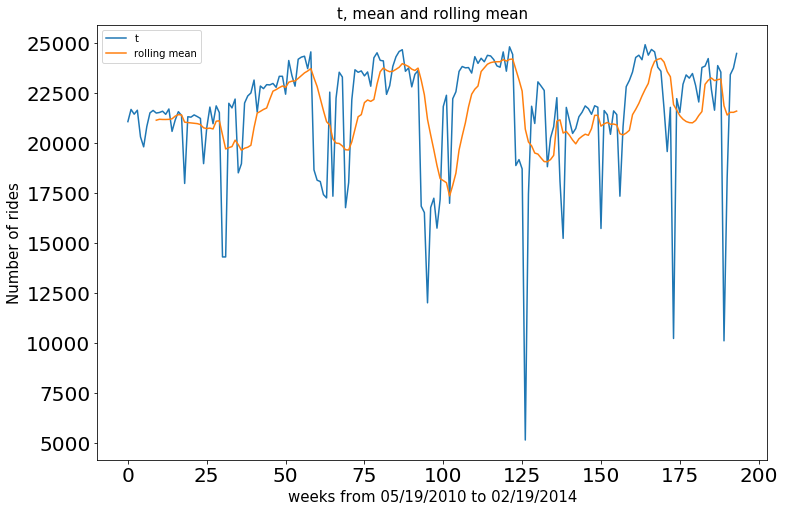

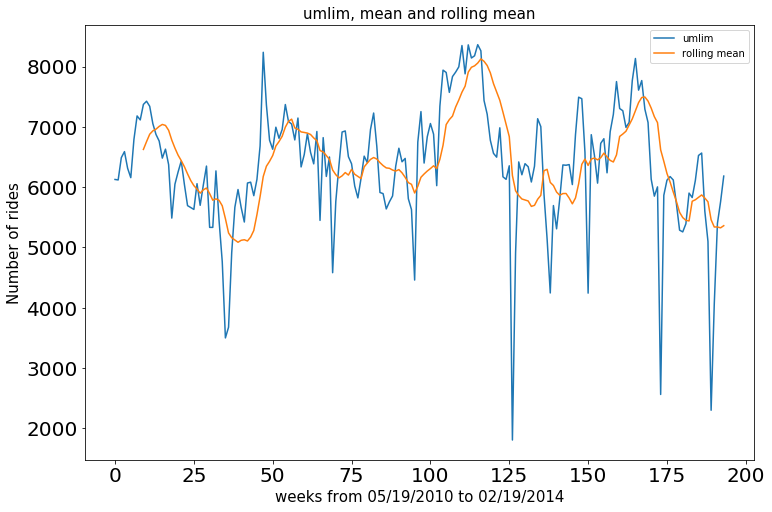

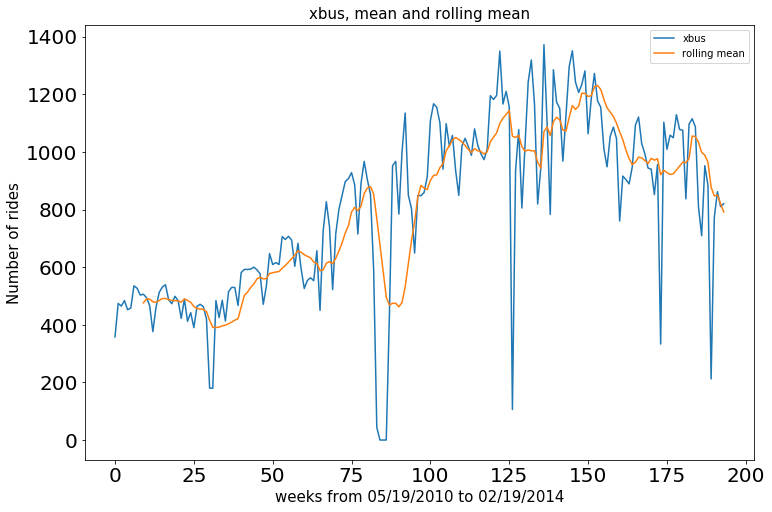

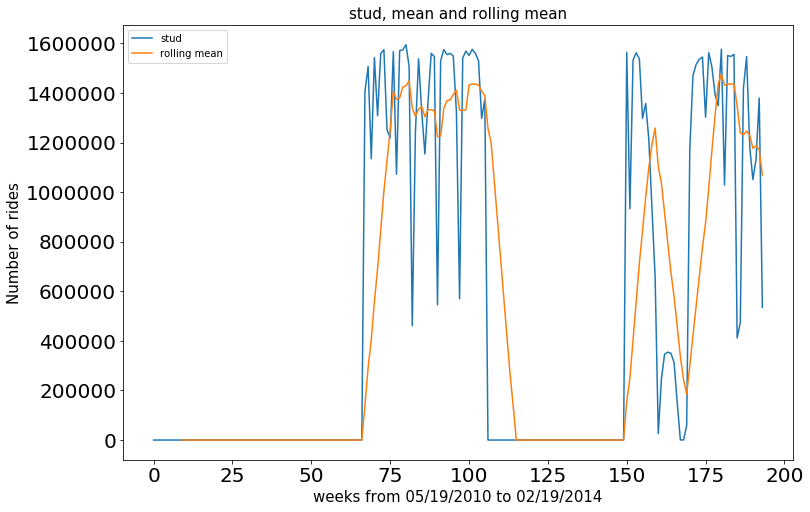

In [19]:
for i in range(23):
    plt.figure(figsize = (12, 8))
    plt.plot(np.arange(len(card_type[i])), card_type[i], label= ridetype[i])
    rmean = pd.rolling_mean(card_type[i], 10)
    plt.plot(np.arange(len(card_type[i])), rmean, label= "rolling mean")
    
    plt.title("{}, mean and rolling mean".format(ridetype[i]), fontsize=15)
    plt.xlabel("weeks from 05/19/2010 to 02/19/2014", fontsize=15)
    plt.ylabel("Number of rides", fontsize=15)
    plt.legend(fontsize=10)

In [20]:
card_type_df = pd.DataFrame(card_type).T
card_type_df.columns = ridetype
card_type_df.dropna
card_type_df.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


In [21]:
change_ratio = []
for i in ridetype:
    change_ratio.append(pd.rolling_mean(card_type_df[i], 10).head(10).mean()
                              /pd.rolling_mean(card_type_df[i], 10).tail(10).mean())

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


In [22]:
change_ratio_card_type = pd.DataFrame([ridetype, change_ratio]).T
change_ratio_card_type.columns = ['card_type', 'changing ratio']
change_ratio_card_type.sort_values(by = 'changing ratio', ascending = False)

,card_type,changing ratio
9,ez,503545
8,exp,94109.1
7,afas,4924.35
13,month,1.66127
14,rfm,1.53947
20,umlim,1.18547
10,ff,1.15499
6,ada,1.08593
3,2t,1.02776
0,10t,0.951682


### Combined the plot and changing ratio above, we can learn that:
- card type'ez' has the steepest drop down and 'stud' has the steepest increase;
- card type afas, exp, ez, mr has an extreme dropping down and mr, stud has an extreme increase.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [23]:
# Learned From Xiaoning He
label = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        label.append(j)
        
label = np.array(label[:9317])    

label.shape

(9317,)

In [24]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [25]:
# mtaRidesPerWeek = np.nansum(station, axis = 0)
# mtaRidesPerWeek.shape -> (194,)
# card_type = np.nansum(data, axis = 0)
# card_type.shape -> (23, 194)
station = np.nansum(data, axis = 1)
station.shape

(600, 194)

In [26]:
stationsmeans = np.nanmean(station, axis=1)
stationsmeans.shape

(600,)

In [27]:
stationsstd = np.nanstd(station, axis=1)
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [28]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [29]:
tots = mta.reshape(600*23,194)[:9317]
tots.shape

(9317, 194)

In [30]:
# Learn From Xiaoning He & Tiancheng Yin
df = pd.DataFrame(tots)
normed_time_series_mean = []
normed_time_series_std = []
for i in range(tots.shape[0]):
    normed_time_series_mean.append(df.loc[i].mean() / stationsmeans[i//23])
    normed_time_series_std.append(df.loc[i].std() / stationsstd[i//23])

In [31]:
normed_time_series_std[:10]

[0.50485463806321929,
 0.014653692678826652,
 0.0019081644093127605,
 0.0054358213862827362,
 0.003880074676510924,
 0.16908413983679321,
 0.28286505642987902,
 0.00050565008484005345,
 0.062450118070721213,
 0.026758661553077649]

In [32]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape

(9317,)

In [33]:
tsmean[:10]

array([  5.79828866e+04,   1.80932474e+03,   2.34865979e+02,
         7.30041237e+02,   2.90108247e+02,   1.98267680e+04,
         3.02422629e+04,   8.47422680e+00,   9.67087629e+02,
         4.26824742e+02])

In [34]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev[:10]

array([ 18634.01356896,    540.86282986,     70.42970157,    200.63432488,
          143.21224115,   6240.83828981,  10440.45335489,     18.66337324,
         2305.01269034,    987.653128  ])

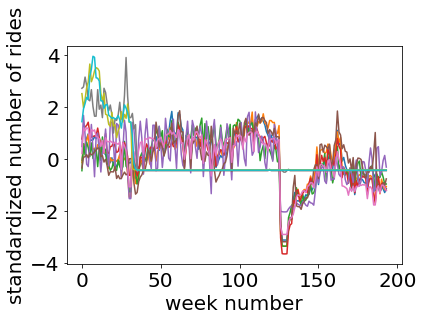

In [35]:
# Learn From Xiaoning He
standardizedts = []
for i in range(9317):
    temp=[]
    temp.append((df.loc[i] - tsmean[i])/tsstdev[i])
    standardizedts.append(np.array(temp).reshape(194,))
standardizedts = np.array(standardizedts)

x=range(194)
for i in range(10):
    pl.plot(x,standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [41]:
# Learn From Xiaoning He & Tiancheng Yin
index = []
for i in range(0, len(standardizedts)):
    for j in range(0, len(standardizedts[i])):
        if np.isnan(standardizedts[i][j]):
            index.append(i)
index = np.unique(np.array(index))

X = []
Y = []
for i in range(0, len(standardizedts)):
    if i in index:
        continue
    else:
        Y.append(label[i])
        X.append(standardizedts[i])

In [42]:
allfits = []
for i in range(len(X)):
    x = X[i]
    y = Y[i]
    md = sm.OLS([y], [x]).fit()
    allfits.append(md)
[a.params[0] for a in allfits[:10]]

[0.0,
 -0.00073693573250744248,
 -0.0046644419049446445,
 0.011789317184561717,
 0.0097745132597100645,
 -0.0089730215269239379,
 0.0063000496631205674,
 0.097683033270458852,
 0.10315326388927076,
 0.066144394514955213]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [43]:
a,b = tsmean/normed_time_series_mean, tsstdev/normed_time_series_std ## Learn From Yiancheng Yin's Code
normedtsmean = []
normedtsstd = []
for i in range(len(a)):
    if i in index:
        continue   
    else:
        normedtsmean.append(a[i])
        normedtsstd.append(b[i])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normedtsmean, normedtsstd]).T,
    Y, test_size=0.33, random_state=42, shuffle=True)

In [45]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5252, 4), (2588, 4), (5252,), (2588,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [64]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [74]:
X_train[~np.isfinite(X_train)] = 0
# ... make a choice about what to do with this datapoint. drop it or replace it with something

In [75]:
# Learn From Xiaoning He 
clf = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

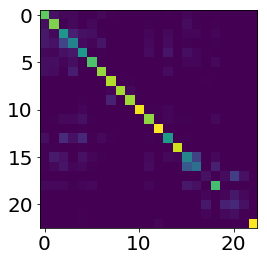

In [76]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [77]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.33, random_state=42, shuffle=True)

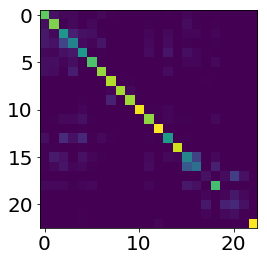

In [78]:
imshow(confusion_matrix(y_test, y_pred))

In [79]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.69      0.82      0.75       128
        14d       0.71      0.85      0.78       131
         1d       0.48      0.61      0.53       120
         2t       0.53      0.48      0.50       130
        30d       0.59      0.64      0.62       115
         7d       0.84      0.80      0.82       125
        ada       0.87      0.82      0.85       142
       afas       0.88      0.98      0.93       125
        exp       1.00      0.96      0.98       125
         ez       0.97      0.89      0.93       133
         ff       1.00      0.96      0.98       142
         mc       0.85      0.85      0.85       137
         mr       0.98      0.99      0.99       140
      month       0.73      0.60      0.66       127
        rfm       0.98      0.98      0.98       132
         rr       0.49      0.49      0.49       128
        sen       0.55      0.41      0.47       124
       spec       0.29      0.15      0.19   